In [ ]:
# Functions Import
import pandas as pd
import numpy as np
import io
import joblib
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn.decomposition import PCA
pca = PCA()
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy import cluster
import seaborn as sns; sns.set()  # for plot styling
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
# concatenate all weekday data
totalMatrix = pd.read_csv('/content/drive/MyDrive/ML Project/totalMatrix_cleaned.csv')
totalMatrix = totalMatrix.drop('Unnamed: 0', 1)
X = totalMatrix.drop(' Label', 1)
y = totalMatrix[' Label']
# replace all non-Benign labels to "Attack"
# effectively a binary label now
y.loc[~(y == 'BENIGN')]='ATTACK'
#display(totalMatrix)
print(totalMatrix.shape)

In [ ]:
# for multiclass classification
totalMatrix = pd.read_csv('/content/drive/MyDrive/ML Project/totalMatrix_cleaned.csv')
totalMatrix = totalMatrix.drop('Unnamed: 0', 1)
X = totalMatrix.drop(' Label', 1)
y = totalMatrix[' Label']
y.loc[(y == 'Web Attack � Brute Force')] ='Web Attack'
y.loc[(y == 'Web Attack � XSS')] ='Web Attack'
y.loc[(y == 'Web Attack � Sql Injection')] ='Web Attack'

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, Cmap, figsize = (20,14), fontsize=12):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Note that due to returning the created figure object, when this funciton is called in a
    notebook the figure willl be printed twice. To prevent this, either append ; to your
    function call, or modify the function by commenting out the return expression.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, cmap=Cmap, square=True, annot=True, fmt='d', cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Note that due to returning the created figure object, when this funciton is called in a notebook
    # the figure willl be printed twice. To prevent this, either append ; to your function call, or
    # modify the function by commenting out this return expression.
    return fig

# Part 1: Testing Data Extraction
Randomly select 20% from each day for test data

In [ ]:
# return matrices:
# trainig         -- X_train -- (2262300 x 78)
# training_label  -- y_train -- (2262300 x 1)
# testing         -- X_test  -- (565576 x 78)
# testing_label   -- y_test  -- (565576 x 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# obtain a 0 --> Benign, 1 --> Attack, binary label array
#unsupervised_y_train = np.array([y_train == 'BENIGN']).T

# Part 2: Feature Pre-processing
## steps

1. Extract all attack rows from training data (identify anything but 'BENIGN' on last column)
2. Randomly select BENIGN rows from the rest of training data. <font color = 'orange'>Our goal is to number-wise match 10 BENIGN data to 1 ANOMALY data so that the weights of attacks are emphasized for feature pre-processing.</font>
3. Combine the two matrices and run PCS algorithm.


In [ ]:
# Normalization
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# PCA
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
# variances
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

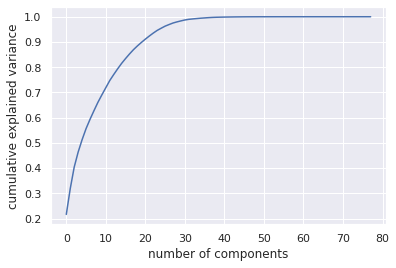

In [ ]:
#decide on number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
# 30 components accounts for over 95%of cumulative variance
pca = PCA(n_components=30)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
y_train.value_counts()

BENIGN              1817404
DoS Hulk             184099
PortScan             126866
DDoS                 102337
DoS GoldenEye          8213
FTP-Patator            6334
SSH-Patator            4698
DoS slowloris          4577
DoS Slowhttptest       4416
Web Attack             1752
Bot                    1564
Infiltration             31
Heartbleed                9
Name:  Label, dtype: int64

# Part 3: Unsupervised Learning
## Outline

1. K-means
2. Gaussian-Mixture Model

In [ ]:
# code for K-means
cluster = KMeans(n_clusters=2, random_state = 0).fit_predict (X_train) 
# modify such that 0 is benign and 1 is attack
if np.bincount(cluster)[0] > np.bincount(cluster)[1]:
    cluster = 1 - cluster
# create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.scatter(X_train[cluster == 0, 0] , X_train[cluster == 0, 1], label='Attack')
ax.scatter(X_train[cluster == 1, 0] , X_train[cluster == 1, 1], label='Benign')
legend = ax.legend(loc='upper right', fontsize='large')
plt.show()

In [ ]:
print("Total number of mtached labels from Kmeans: ", accuracy_score(unsupervised_y_train, cluster, normalize=False))
print()
print(classification_report(unsupervised_y_train, cluster))
mat = confusion_matrix(unsupervised_y_train, cluster)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['ATTACK', 'BENIGN'],
            yticklabels=['ATTACK', 'BENIGN'])
plt.title('KMeans Confusion Matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
# code for GMM
gm = GaussianMixture(n_components=2,  covariance_type='full', random_state=0).fit_predict(X_train)
# modify such that 0 is benign and 1 is attack
if np.bincount(gm)[0] > np.bincount(gm)[1]:
    gm = 1 - gm
fig, ax = plt.subplots()
ax.scatter(X_train[gm == 0, 0] , X_train[gm == 0, 1], label='Attack')
ax.scatter(X_train[gm == 1, 0] , X_train[gm == 1, 1], label='Benign')
legend = ax.legend(loc='upper right', fontsize='large')
plt.show()

In [ ]:
print("Total number of mtached labels from GMM: ", accuracy_score(unsupervised_y_train, gm, normalize=False))
print()
print(classification_report(unsupervised_y_train, gm))
mat = confusion_matrix(unsupervised_y_train, gm)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['ATTACK', 'BENIGN'],
            yticklabels=['ATTACK', 'BENIGN'])
plt.title('GMM Confusion Matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

# Part 4: Supervised Learning -- Random Forest

In [ ]:
# code for Random Forest
#model = RandomForestClassifier(n_estimators=6, max_features='sqrt', max_depth=45, min_samples_split=15, min_samples_leaf=3)
model = RandomForestClassifier(n_estimators=20)
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print(confusion_matrix(y_test, ypred))

[[111318    342]
 [   349 453567]]


              precision    recall  f1-score   support

      ATTACK     0.9969    0.9969    0.9969    111667
      BENIGN     0.9992    0.9992    0.9992    453909

    accuracy                         0.9988    565576
   macro avg     0.9981    0.9981    0.9981    565576
weighted avg     0.9988    0.9988    0.9988    565576



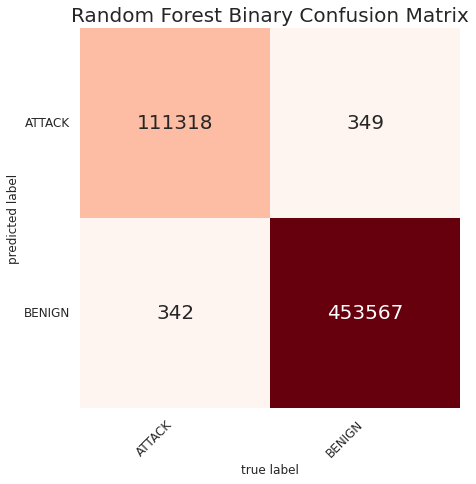

In [ ]:
print(classification_report(ypred, y_test, digits=4))
mat_labels = np.unique(y_train)
mat = confusion_matrix(y_test, ypred).T
mat_df = pd.DataFrame(mat, index=mat_labels, columns=mat_labels)
cmap = sns.diverging_palette(20,10, as_cmap=True)
print_confusion_matrix(mat_df, mat_labels, Cmap="Reds", figsize = (10, 7))
#sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap=cmap
#            xticklabels=['ATTACK', 'BENIGN'],
#            yticklabels=['ATTACK', 'BENIGN'])
plt.title('Random Forest Binary Confusion Matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

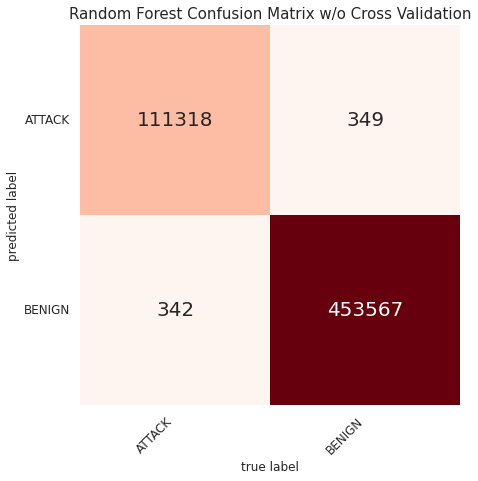

In [ ]:
cmap = sns.diverging_palette(20,10, as_cmap=True)
print_confusion_matrix(mat_df, mat_labels, Cmap="Reds", figsize = (10, 7))
plt.rc('font', size=12)
plt.rc('axes', titlesize=15)
plt.title('Random Forest Confusion Matrix w/o Cross Validation')
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
ypred = model.predict(X_test)
print(classification_report(ypred, y_test, digits=4))
mat_labels = np.unique(y_train)
mat = confusion_matrix(y_test, ypred).T
mat_df = pd.DataFrame(mat, index=mat_labels, columns=mat_labels)
plt.rc('font', size=12)
print_confusion_matrix(mat_df, mat_labels, Cmap=sns.color_palette("crest", as_cmap=True))
plt.title('Random Forest Multiclass Confusion Matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
f, ax = plt.subplots(figsize=(20, 14))
plot = sns.barplot(x=np.arange(1, 31), y=model.feature_importances_)
ax.set_title('Feature Importance (Random Forest Multiclass)')
plot.set_xticklabels(plot.get_xticklabels())
plt.xlabel('PCA Transformed Features')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.show()

# Part 5: Joblib Saving Model -- Random Forest

In [ ]:
# save
#joblib.dump(model, "rf_e6_dep45_splt15_leaf3.joblib")
model = joblib.load("xgb_dep43_n6.joblib")

In [ ]:
# load
#model2 = joblib.load("e6_dep43_splt10_leaf3.joblib")
ypred = model.predict(X_test)
print(classification_report(ypred, y_test, digits=4))

mat_labels = np.unique(y_train)
mat = confusion_matrix(y_test, ypred).T
mat_df = pd.DataFrame(mat, index=mat_labels, columns=mat_labels)
plt.rc('font', size=12)
print_confusion_matrix(mat_df, mat_labels, figsize = (10,7), Cmap=sns.light_palette("seagreen", as_cmap=True))
plt.title('XGBoost Binary Confusion Matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
f, ax = plt.subplots(figsize=(20, 14))
plot = sns.barplot(x=np.arange(1, 31), y=model.feature_importances_)
ax.set_title('Feature Importance (XGBoost Binary)')
plot.set_xticklabels(plot.get_xticklabels())
plt.xlabel('PCA Transformed Features')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.show()

In [ ]:
import graphviz
xgb.to_graphviz(model, num_trees=1)

# Part 7: XGBoost

In [ ]:
xgb_classifier = xgb.XGBClassifier(booster='gbtree', objective="binary:logistic", subsample=0.8,
                                   n_estimators=6, max_features='sqrt', max_depth=45, min_samples_split=15, min_samples_leaf=3)
xgb_model = xgb_classifier.fit(X_train, y_train)
ypred = xgb_model.predict(X_test)
#print(confusion_matrix(y_test, ypred))

In [ ]:
#joblib.dump(xgb_model, "xgb_dep43_n6.joblib")
#xgb_model2 = joblib.load("xgb_dep43_n6.joblib")
ypred = xgb_model.predict(X_test)
print(classification_report(ypred, y_test, digits=4))
mat = confusion_matrix(y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['ATTACK', 'BENIGN'],
            yticklabels=['ATTACK', 'BENIGN'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
xgb_classifier = xgb.XGBClassifier(booster='gbtree', objective="multi:softmax", subsample=0.6,
                                   n_estimators=6, max_features='sqrt', max_depth=45, min_samples_split=15, min_samples_leaf=3)
xgb_model = xgb_classifier.fit(X_train, y_train)
ypred = xgb_model.predict(X_test)
#print(confusion_matrix(y_test, ypred))

In [ ]:
mat_labels = np.unique(y_train)
mat = confusion_matrix(y_test, ypred).T
mat_df = pd.DataFrame(mat, index=mat_labels, columns=mat_labels)
print_confusion_matrix(mat_df, mat_labels, Cmap='Greens')
plt.title('XGBoost Multiclass Confusion Matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

# Part 4-2: Random Forest Cross Validation

In [ ]:
# since trainning for RF is rather time-intensive, we will use RandomizedSearchCV
# for cross-validation
n_estimators = [6, 7]
max_depth = [int(x) for x in np.linspace(40, 45, num = 6)]
max_depth.append(None)
min_samples_leaf = [2, 3, 4, 5]
min_samples_split = [8, 10, 12, 14]
max_features = ['sqrt', 'log2']
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features}
print(random_grid)

In [ ]:
# cross-validation with scoring based on recall
rf = RandomForestClassifier()
rf_random  = RandomizedSearchCV(estimator=rf, scoring='recall', param_distributions=random_grid, n_iter=5, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

In [ ]:
# visualizing the confusion matrix of the best model out of RandomizedSearchCV
rf_best = rf_random.best_estimator_
ypred = rf_best.predict(X_test)
mat = confusion_matrix(y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['ATTACK', 'BENIGN'],
            yticklabels=['ATTACK', 'BENIGN'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');
print([estimator.get_depth() for estimator in rf_best.estimators_])

# Part Last: other codes

In [ ]:
#all disposable codes
"""
from google.colab import drive
drive.mount('drive')
totalMatrix = pd.read_csv('/content/drive/MyDrive/ML Project/totalMatrix_cleaned.csv')
totalMatrix.to_csv('totalMatrix_cleaned.csv')
!cp totalMatrix_cleaned.csv "drive/My Drive/"
mon_data = pd.read_csv('/content/drive/MyDrive/ML Project/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv')
tues_data = pd.read_csv('/content/drive/MyDrive/ML Project/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv')
wed_data = pd.read_csv('/content/drive/MyDrive/ML Project/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv')
thrs_morning_data = pd.read_csv('/content/drive/MyDrive/ML Project/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
thrs_afternoon_data = pd.read_csv('/content/drive/MyDrive/ML Project/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
fri_morning_data = pd.read_csv('/content/drive/MyDrive/ML Project/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv')
fri_port_data = pd.read_csv('/content/drive/MyDrive/ML Project/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
fri_ddos_data = pd.read_csv('/content/drive/MyDrive/ML Project/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
totalMatrix = pd.concat([mon_data, tues_data, wed_data, thrs_morning_data, thrs_afternoon_data, fri_morning_data, fri_port_data, fri_ddos_data], axis=0)
# Get rid of all data points with NaN and inf
with pd.option_context('mode.use_inf_as_na', True):
  totalMatrix = totalMatrix.dropna()
benign_1 = np.array([mon_data.iloc[:, 78] == 'BENIGN']).T
print(mon_data.shape[0] - np.sum(benign_1))
benign_2 = np.array([tues_data.iloc[:, 78] == 'BENIGN']).T
print(tues_data.shape[0] - np.sum(benign_2))
benign_3 = np.array([wed_data.iloc[:, 78] == 'BENIGN']).T
print(wed_data.shape[0] - np.sum(benign_3))
benign_4 = np.array([thrs_data.iloc[:, 78] == 'BENIGN']).T
print(thrs_data.shape[0] - np.sum(benign_4))
benign_5 = np.array([fri_data.iloc[:, 78] == 'BENIGN']).T
print(fri_data.shape[0] - np.sum(benign_5))
"""
"""
benign_mask = np.array([y_train == 'BENIGN']).T
attack_mask = np.invert(benign_mask)
training_attack = X_train.iloc[attack_mask, :]
# random selection of training_benign
choices = np.random.choice(np.sum(benign_mask), size = 2 * np.sum(attack_mask), replace = False)
training_benign = X_train.iloc[choices, :]
# concatenate training_attack and training_benign for pca dimensionality reduction
pca_input_matrix = pd.concat([training_attack, training_benign], axis=0)
#print(pca_input_matrix.shape)
from ast import increment_lineno
%matplotlib increment_lineno
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predict')
plt.ylabel('Truth')
"""

In [ ]:
from sklearn.svm import SVC

In [ ]:
model = SVC(kernel='rbf', C=100, gamma=0.001)
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print(model.score(X_test, y_test))

In [ ]:
#print(classification_report(ypred, y_test, digits=4))
mat = confusion_matrix(y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['ATTACK', 'BENIGN'],
            yticklabels=['ATTACK', 'BENIGN'])
plt.title('Support Vector Machine Confusion Matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');